In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def get_sin_sample(n=10, sigma=0.05, mean=0, xlim=(0,1), bins=None): # latin hypercube sampling
    if bins is None:
        bins = n
    
    step = (xlim[1] - xlim[0]) / bins
    k = int(np.ceil(n/bins))
    x = np.zeros(n)
    
    s = 0
    e = step
    pos = 0
    for i in range(0, bins):
        x[pos:pos+k] = np.random.uniform(s, e, k)
        s = e
        e += step
        pos += k
    
    last = n - bins
    if pos != n:
        x[pos:] = np.random.uniform(0, 1, n - pos)
    
    y = np.sin(2 * np.pi * x) 
    y_noised = y + np.random.normal(mean, sigma, n)
    return x, y_noised


In [3]:
n = 10
sigma = 0.15
mean = 0
x, y = get_sin_sample(n=10, mean=mean, sigma=sigma)


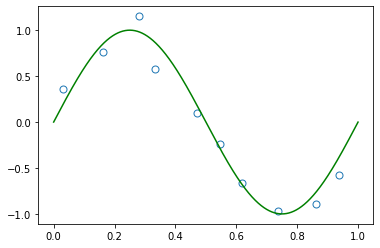

In [4]:
eps = 0.01
xlim = (0, 1)
plt.plot(x, y, marker='o', fillstyle='none', linestyle='none', markersize=7)
xsin = np.arange(xlim[0], xlim[1], (xlim[1] - xlim[0]) / 10000)
ysin = np.sin(2 * np.pi * xsin)
plt.plot(xsin, ysin, color='green')

In [5]:
def make_order_matrix(x, order): 
    # Делаем матрицу признаков. Каждой строке соответствует один объект, каждому столбцу - степень от 0 до order
    X = np.zeros((x.shape[0], order+1))
    X[:, 0] = 1
    X[:, 1] = x
    for i in range(2, order + 1):
        X[:, i] = x ** i
    return X 
    

In [12]:
order = 10

In [13]:
X= make_order_matrix(x, order)
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [14]:
X_grid = make_order_matrix(xsin, order)
y_grid_pred = model.predict(X_grid)

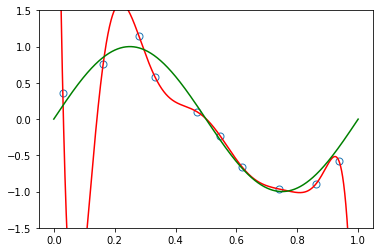

In [15]:
plt.ylim(-1.5, 1.5) # установить предел для оси OY
plt.plot(x, y, marker='o', fillstyle='none', linestyle='none', markersize=7)
plt.plot(xsin, y_grid_pred, color='red')
plt.plot(xsin, ysin, color='green')

Подсчет MSE и MAE

In [16]:
print (mean_squared_error(ysin, y_grid_pred), mean_absolute_error(ysin, y_grid_pred))

1.8721655952340814 0.6282202942423881


# Polyfit. Сравнение

In [17]:
# использование функции
p = np.poly1d(np.polyfit(x, y, order)) # аппроксимация y полиномом степени order от x 
y_pred = p(x)

/Users/dmitrypenzar/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3319: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


# Влияние размера выборки на переобучение

Проверьте, как будет влиять изменения размера выборки на переобучение

# Влияние дисперсии шума на переобучение

Проверьте, как будет влиять изменения дисперсии шума, добавляемого к реальным значениям y на переобучение

# Влияние среднего шума на переобучение

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

In [2]:
np.random.seed(777)

# Проклятье размерности

##  Сэмплируем из многомерного нормального распределения. Построить распределение расстояния до нуля координат. 

In [3]:
np.random.normal(0, 1) # 0 среднее, 1 дисперсия, 1-мерное нормальное распределение

-0.4682087939185533

In [4]:
# 1 точка из 10мерного нормального распределения, все компоненты которого независимы
np.random.normal(0, 1, size=10) 

array([-0.82282485, -0.0653801 , -0.71336192,  0.90635089,  0.76623673,
        0.82605407, -1.32368279, -1.75244452,  1.00244907,  0.54480945])

In [5]:
# 5 njxrt из 10мерного нормального распределения, все компоненты которого независимы
np.random.normal(0, 1, 
                 size=(5, 10)) 

array([[ 1.8951609 , -0.76935745, -1.40309592, -0.63246751, -0.55887367,
        -1.23323138, -0.43950352,  0.91478726,  0.26504093, -1.38337015],
       [ 0.6855118 ,  0.45609091, -0.46137426,  0.0947003 , -1.54281161,
         2.4793696 ,  0.45686676, -0.31387278,  0.02103738,  0.96079316],
       [ 0.0584829 , -0.44603217,  0.31919714,  0.84116862, -1.53276199,
        -0.28158426,  1.74445271, -0.67423891,  0.58840123,  1.80436346],
       [ 2.05625026,  1.45458168, -0.13841169,  0.34287188, -0.72761848,
        -1.4039461 , -1.24061119, -0.44348217, -0.04732516,  0.75768436],
       [-0.15208593, -0.27127901, -0.59983997, -2.02690413,  0.3303424 ,
        -0.330831  , -0.03494216,  0.28974804, -0.60626995, -0.26840428]])

In [6]:
points = np.random.normal(0, 1, 
                 size=(5, 10)) 
# вычисляем расстояние от 5 точек в 10мернорм пространстве до 0
np.linalg.norm(points, axis=1)

array([2.89973527, 2.0129625 , 2.94506712, 3.46182171, 2.28235309])

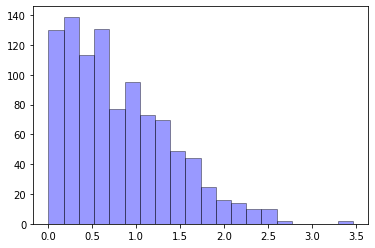

In [7]:
points = np.random.normal(0, 1, 
                 size=(1000, 1)) # вычисляем расстояние от 1000 точек в 1 мерном пространстве до 0
d = np.linalg.norm(points, axis=1)

sns.distplot(d, hist=True, kde=False, color = 'blue',
             hist_kws={'edgecolor':'black'})

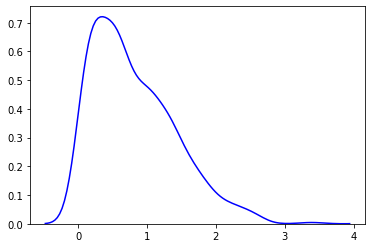

In [8]:
# АППРОКСИМАЦИЯ плотности распределение
sns.distplot(d, hist=False, kde=True, color = 'blue',
             hist_kws={'edgecolor':'black'})

### Постройте распределение расстояния от центра координат до точек для размерностей N=5, N=10, N=20 и N = 200 на одном графике.  Какие выводы можно сделать? 

### * Объясните полученную картину с помощью теории вероятности. 

* Указание: подсчитайте вероятность того, что сумма квадратов N независимых нормальных величин будет меньше R^2 для некоторого фиксированного R. 
* Указание: В принципе, можете вывести формулу для квадратом равномерных. 

## *Повторите графики для равномерного распределения. 

In [9]:
np.random.uniform(low=-1, high=1, size=(5, 2)) # Пять точек из двумерного равномерного распределения, 
# каждая из компонент которого - равномерное распределение на отрезке от -1 до 1. 
# По-другому - точка имеет две координаты, координаты распределены независимо и равномерно на отрезке от 0 до 1

array([[-0.96926204,  0.14556084],
       [ 0.60332078,  0.95412775],
       [-0.81708469, -0.45133309],
       [ 0.51771658,  0.11543315],
       [-0.66035674, -0.79212249]])

## Сфера радиуса R vs Сфера радиуса 2R 



In [10]:
np.random.uniform(low=-2, high=2, size=(5, 2)) # Пять точек из двумерного равномерного распределения, 
# каждая из компонент которого - равномерное распределение на отрезке от -1 до 1. 
# По-другому - точка имеет две координаты, координаты распределены независимо и равномерно на отрезке от 0 до 1

array([[-1.63794654,  0.12669862],
       [-0.54699209, -0.16590838],
       [-1.14531721, -0.62900682],
       [-0.16959131, -1.25361389],
       [-1.23542485,  0.9187676 ]])

In [11]:
def points_in_sphere(points, R): # https://en.wikipedia.org/wiki/N-sphere
    return np.sum(points * points, axis=1) < R 

In [12]:
dim = 5
eps = 0.1
p = np.random.uniform(low=-1, high=1, size=(10000000, dim))


r1 = points_in_sphere(p, 1).sum()
r1eps = points_in_sphere(p, 1 + eps).sum()

# Считаем отношение числа точек, попавших в сферу радиуса 1
# к числу точек, попадающих в сферу радиуса 1 + eps 
print(r1/r1eps)

# Считаем отношение числа точек, не попавших в сферу радиуса 1
# но попавших в сферу радиуса 1 + eps  к числу точек, попавших в сферу радиуса 1 + eps
print( (r1eps - r1)  / r1eps)

0.7890584460739413
0.2109415539260588


#### Постройте график зависимости этих двух величин от размерности пространства. Сделайте выводы

## * Попробуйте повторить что-то из выше перечисленного для другой метрики и опишите ваши наблюдения

# Bias-variance-tradeoff

In [13]:
from sklearn.datasets import make_moons, make_circles, make_classification
from matplotlib.colors import ListedColormap

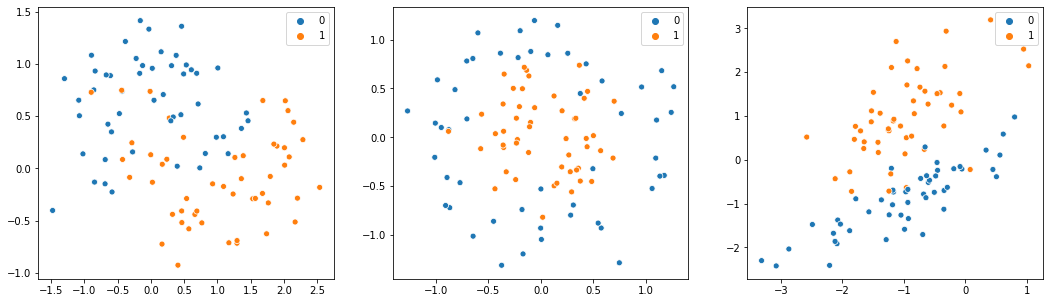

In [14]:


n_samples = 100

# Сгенерируем три различных искуственных датасета
f, axarr = plt.subplots(1, 3, figsize=(18, 5))

# два вложенных в друг друга серпа
points1, labels1 = make_moons(noise=0.3, random_state=371, n_samples=n_samples)
sns.scatterplot(points1[:, 0], points1[:, 1], hue=labels1, ax=axarr[0])

# концентрические окружности
points2, labels2 =  make_circles(noise=0.2, factor=0.5, random_state=371, n_samples=n_samples)
sns.scatterplot(points2[:, 0], points2[:, 1], hue=labels2, ax=axarr[1])

# просто две соприкасающихся группы точек 
points3, labels3 = make_classification(n_features=2, 
                                       n_redundant=0,
                                       n_informative=2,
                                       random_state=20, 
                                       n_clusters_per_class=1,
                                       flip_y=0.01, 
                                       n_samples=n_samples)
points3 = points3 + np.random.normal(0, 0.01, points3.shape)
sns.scatterplot(points3[:, 0], points3[:, 1], hue=labels3, ax=axarr[2])
plt.show()

Выберите датасет, который вам больше нравится.
Например, выберем первый

In [15]:
points, labels = points1, labels1 

In [16]:
n_nei = 1
classifier = KNeighborsClassifier(n_neighbors=n_nei)
classifier.fit(points, labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

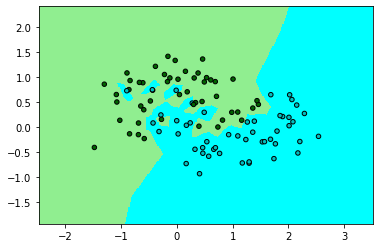

In [17]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
h = .02 # step size for plot grid


cmap_light = ListedColormap(['lightgreen', 'cyan'])
cmap_bold = ListedColormap(['darkgreen', 'c'])


x_min, x_max = points[:, 0].min() - 1, points[:, 0].max() + 1
y_min, y_max = points[:, 1].min() - 1, points[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap=cmap_bold,
                edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

### Визуализируйте decision boundary для разного числа соседей

### Повторите такое же для KNN с weights="distance".

#### Сделайте вывод о зависимости bias и variance KNN в зависимости от числа соседей. 
#### Как влияет шум на bias/variance? 


#### * Повторить такое же для KNN с weights=callable.

#### * Повторить это и для других датасетов. Построить набор графиков: колонка - датасет, строка - число соседей

## Качество классификатора 

In [18]:
# Для оценки качества классификатора используется множество различных метрик. 
# Будем использовать здесь две из них
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split # бьем на train и test

In [19]:
# два вложенных в друг друга серпа
n_samples = 200
X, y = make_moons(noise=0.3, random_state=371, n_samples=n_samples)

# бьем на обучение и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [20]:
y_predicted = model.predict(X_test) # предсказываем класс

# accuracy - просто доля объектов, для которых мы верно указали класс
print(accuracy_score(y_true=y_test, y_pred=y_predicted)) 

0.9


In [21]:
y_predicted = model.predict_proba(X_test) # предсказываем вероятность классов
print(y_predicted.shape)
y_predicted_1class = y_predicted[:, 1] # берем вероятности первого класса

(80, 2)


In [22]:
print(roc_auc_score(y_true=y_test, y_score=y_predicted_1class)) 

0.9108818011257035


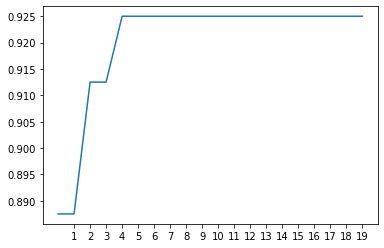

In [23]:
# строим зависимость accuracy от числа соседей,  weights="uniform"
max_n = 20
wu = np.zeros(max_n)

for n in range(1, max_n + 1):
    model = KNeighborsClassifier(n_neighbors=n, weights="distance")
    model.fit(X_train, y_train)
    
    y_predicted = model.predict(X_test)
    wu[n-1] = accuracy_score(y_true=y_test, 
                          y_pred=y_predicted)

plt.xticks(np.arange(1, max_n))
plt.plot(wu)

#### Выберите какой-то датасет и постройте для него зависимость accuracy и roc-auc от числа соседей для weights="uniform" и weights="distance". Выберите оптимальное число соседей. 

## Предсказываем значение функции с помощью KNN-регрессор

In [24]:
from mpl_toolkits.mplot3d import Axes3D # для 3d-визуализации в matplotlib
from matplotlib import cm 

In [25]:
gridspec_kw={'width_ratios': [3, 1]}

In [26]:
points[:, 1].min()

-0.92616308816364

In [27]:
# пусть у нас будет функция от двух переменных
x1_min, x1_max = -2.5, 2.5
x2_min, x2_max = -2.5, 2.5
x1, x2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                         np.arange(x2_min, x2_max, h))

y = np.cos(x1) ** 2 + np.sin(x2) ** 2

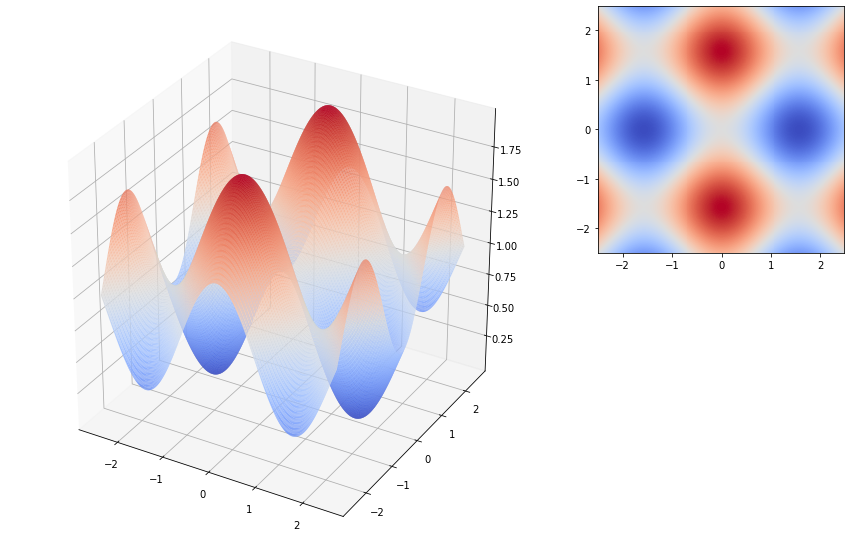

In [28]:
# Построим, как это выглядит 
plt.figure(figsize=(15,10))
# https://towardsdatascience.com/subplots-in-matplotlib-a-guide-and-tool-for-planning-your-plots-7d63fa632857 
ax = plt.subplot2grid((2, 3), (0, 0), rowspan=2, colspan=2, projection='3d') 

ax.plot_surface(x1, x2, y, cmap=cm.coolwarm, linewidth=0, rstride=1, cstride=1)

ax = plt.subplot2grid((2, 3), (0, 2), rowspan=1, colspan=1)
ax.pcolormesh(x1, x2, y, cmap=cm.coolwarm, )
plt.show()

In [31]:
x1.shape

(250, 250)

In [34]:
sample_size = 500

x1_sample = np.random.uniform(x1_min, x1_max, sample_size)
x2_sample = np.random.uniform(x2_min, x2_max, sample_size)

noise = np.random.normal(0, 0.2, sample_size)
y_sample = np.cos(x1_sample) ** 2 + np.sin(x2_sample) ** 2 + noise


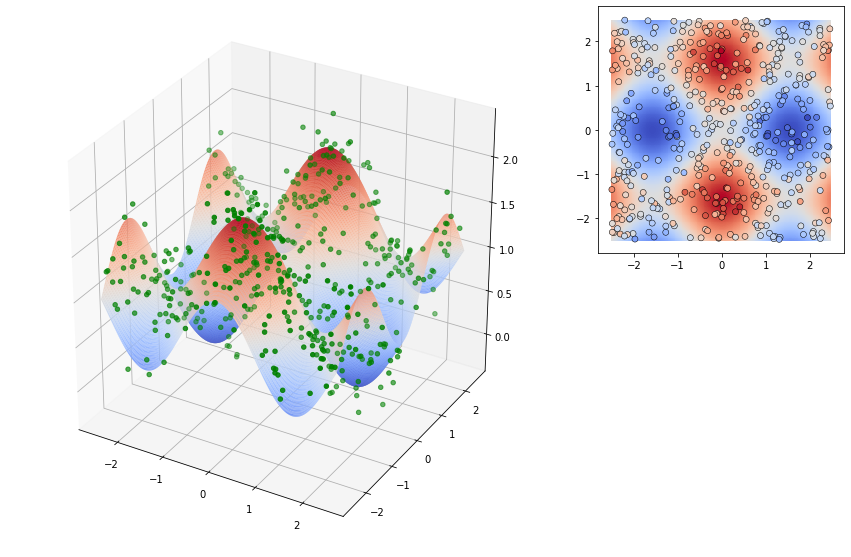

In [35]:
# Построим, как это выглядит 
plt.figure(figsize=(15,10))

ax = plt.subplot2grid((2, 3), (0, 0), rowspan=2, colspan=2, projection='3d') 

ax.plot_surface(x1, x2, y, cmap=cm.coolwarm, linewidth=1, rstride=1, cstride=1)
ax.scatter3D(x1_sample, x2_sample, y_sample, color='g')


ax = plt.subplot2grid((2, 3), (0, 2), rowspan=1, colspan=1)

ax.pcolormesh(x1, x2, y, cmap=cm.coolwarm)
ax.scatter(x1_sample, x2_sample, c=y_sample, cmap=cm.coolwarm, edgecolor='black', linewidth=0.5)
plt.show()

In [42]:
regressor = KNeighborsRegressor(n_neighbors=5, weights='distance')
X_sample = np.stack([x1_sample, x2_sample], axis=1) # make matrix
regressor.fit(X_sample, y_sample)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='distance')

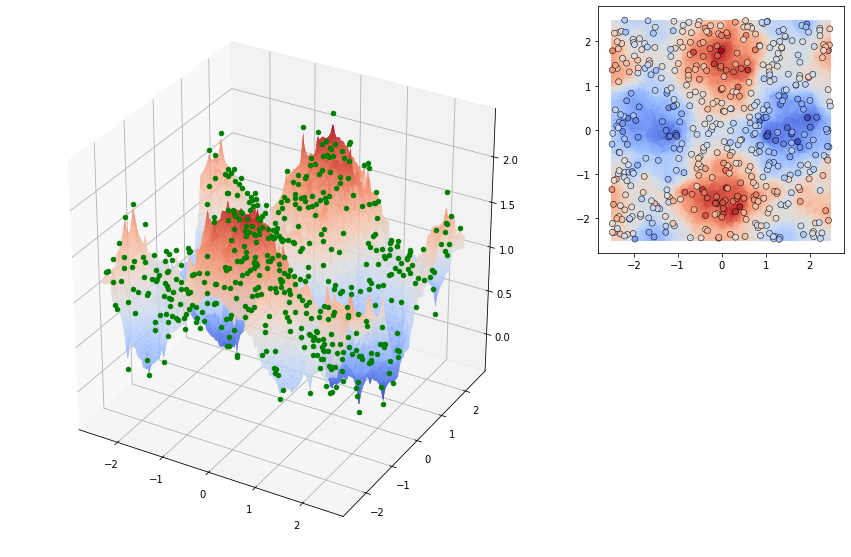

In [43]:
X = np.stack([np.ravel(x1), np.ravel(x2)], axis=1)
y_predicted = regressor.predict(X)
y_predicted = y_predicted.reshape(x1.shape[0], x1.shape[1])

# Построим, как это выглядит 
plt.figure(figsize=(15,10))

ax = plt.subplot2grid((2, 3), (0, 0), rowspan=2, colspan=2, projection='3d') 

ax.plot_surface(x1, x2, y_predicted, cmap=cm.coolwarm, linewidth=1, rstride=1, cstride=1)
ax.scatter3D(x1_sample, x2_sample, y_sample, color='g', depthshade=False)

ax = plt.subplot2grid((2, 3), (0, 2), rowspan=1, colspan=1)

ax.pcolormesh(x1, x2, y_predicted, cmap=cm.coolwarm)
ax.scatter(x1_sample, x2_sample, c=y_sample, cmap=cm.coolwarm, edgecolor='black',
           linewidth=0.5)
plt.show()

#### Изобразите, что получится для бОльшего числа соседей. В идеале - подберите число соседей, при котором функция будет воспроизводиться наиболее точно.

#### Аналогично изобразите, что получится, если поставить параметр weights="distance".В идеале - подберите число соседей, при котором функция будет воспроизводиться наиболее точно. 

## Качество регрессионной модели

In [101]:
# Можно считать MSE - Mean Squared Error, 
# можно MAE - Mean Absolute Error (https://en.wikipedia.org/wiki/Mean_absolute_error) 
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Мы будем далее использовать MAE (у нас y часто меньше 1, удобнее).
# Можете использовать MSE, если интересно. 

# разбиение выборки на обучение и тест
# в принципе, мы можем в данном синтетическом примере не использовать этого, 
# а использовать _sample и grid
# но в реальности, конечно, всех данных о функции у вас нет. Только немного данных, которые вы бьете
# на трэйн и тест 
from sklearn.model_selection import train_test_split

In [102]:
y = np.ravel(y) # перевести двумерный массив y в одномерный

# опять же, обычно соотношение train и test берут не 0.01/0.995, а, например, 3:2
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.995) 


In [103]:
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train, y_train)

y_predicted = model.predict(X_test)
print(mean_absolute_error(y_true=y_test, 
                          y_pred=y_predicted))

0.07682707700297407


In [104]:
model = KNeighborsRegressor(n_neighbors=3, weights="distance")
model.fit(X_train, y_train)

y_predicted = model.predict(X_test)
print(mean_absolute_error(y_true=y_test, 
                          y_pred=y_predicted))

0.06466429194018966


Постройте на одном графике зависимость mse модели от числа соседей для weights="uniform" (стоит по-умолчанию) и для weights="distance" на одном графике. Выберите оптимальное число соседей. Что лучше себя показывает - weights="uniform" или weights="distance"?

Проверьте, как будет влиять изменения среднего шума, добавляемого к реальным значениям y на переобучение